<a href="https://colab.research.google.com/github/SawairaK/Cross_validation_types/blob/main/Cross_Validation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing the libraries
**lightgbm** **is machine learning library.**
LightGBM is a gradient boosting framework that uses tree based learning algorithms. It is designed to be distributed and efficient with the following advantages:



1.   Faster training speed and higher efficiency.
2.   Support of parallel, distributed, and GPU learning.
3.   Capable of handling large-scale data
4.   Better accuracy.

In [41]:
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import lightgbm as lgb

from sklearn.metrics import accuracy_score, roc_auc_score

from sklearn.model_selection import (
    train_test_split,
    TimeSeriesSplit,
    KFold,
    StratifiedKFold,
    GroupKFold,
    StratifiedGroupKFold,
)

plt.style.use('seaborn-white')

<ipython-input-41-80ed9307fc65>:18: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


## The Dataset
This function read data with pandas it sets the format of data and then simply split the dataset into our training and testing part.
so it use in general if we give other dataset like data in future that we plan to run model on

In [42]:
def get_prep_data():
    data = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')

    data["ever_married"] = (
        data["ever_married"].replace("Yes", True).replace("No", False)
    )

    data["gender"] = data["gender"].astype("category")
    data["smoking_status"] = data["smoking_status"].astype("category")
    data["Residence_type"] = data["Residence_type"].astype("category")
    data["work_type"] = data["work_type"].astype("category")
    data["doctor"] = np.random.randint(0, 8, size=len(data))
    holdout_ids = data.sample(n=500, random_state=529).index

    train = (
        data.loc[~data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )
    holdout = (
        data.loc[data.index.isin(holdout_ids)]
        .sample(frac=1, random_state=529)
        .sort_values("doctor")
        .reset_index(drop=True)
    )

    return train, holdout

train, holdout = get_prep_data()


The Stroke column is either 0 or 1 that we want to predict, whether a person have stroke or not.

In [43]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,doctor
0,37698,Female,15.0,0,0,False,children,Urban,87.96,21.5,formerly smoked,0,0
1,24058,Female,50.0,0,0,True,Govt_job,Rural,77.67,25.6,never smoked,0,0
2,27572,Female,25.0,0,0,False,Private,Rural,92.82,24.1,never smoked,0,0
3,36593,Male,38.0,0,0,False,Private,Rural,162.72,31.9,smokes,0,0
4,60056,Male,53.0,0,0,True,Private,Urban,113.21,28.6,smokes,0,0


See the columns foe our Feature data X and target Y.

In [44]:
train.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke', 'doctor'],
      dtype='object')

We have these Features in our dataset and the groups which is the doctor(whose gonna get the data) and the strokes that we are trying to predict.

In [45]:
def get_X_y(train):
    FEATURES = [
        "gender",
        "age",
        "hypertension",
        "heart_disease",
        "ever_married",
        "work_type",
        "Residence_type",
        "avg_glucose_level",
        "bmi",
        "smoking_status",
    ]

    GROUPS = "doctor"

    TARGET = "stroke"

    X = train[FEATURES]
    y = train[TARGET]
    groups = train[GROUPS]
    return X, y, groups


## Creating a classifier

lgbm thats a gradient boosted tree ML model, set parameters numbers of estimators

In [46]:
X, y, groups = get_X_y(train)
classifier = lgb.LGBMClassifier(n_estimators=100)
classifier.fit(X, y)

[LightGBM] [Info] Number of positive: 223, number of negative: 4387
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000396 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4610, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.048373 -> initscore=-2.979229
[LightGBM] [Info] Start training from score -2.979229


LGBMClassifier()

In [47]:
# Predict on training set
pred = classifier.predict(X)

# Predict the Probabilities instead of Binary Values
pred_prob = classifier.predict_proba(X)[:, 1]
pred_prob

array([9.65900938e-05, 1.30846105e-02, 1.40245540e-04, ...,
       6.29188044e-05, 1.11648109e-03, 9.56244336e-05])

In [48]:
acc_score = accuracy_score(y, pred)
auc_score = roc_auc_score(y, pred_prob)

print(f'The score on the training set is accuracy: {acc_score:0.4f} and AUC of {auc_score:0.4f}')

The score on the training set is accuracy: 0.9911 and AUC of 0.9997


## Check on holdout set
We keep some data to the side as a holdout set, that we suppose it will be the future data that we will use our model to predict on, we can check score on that to see if the model scpre ic 99% accurate or not.

In [49]:
X_holdout, y_holdout, groups_holdout = get_X_y(holdout)

pred = classifier.predict(X_holdout)
pred_prob = classifier.predict_proba(X_holdout)[:, 1]
acc_score = accuracy_score(y_holdout, pred)
auc_score = roc_auc_score(y_holdout, pred_prob)
print(
    f"Our accuracy on the holdout set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

Our accuracy on the holdout set is 0.9380 and AUC is 0.7802


# Baseline
Predicting all zeros

As we predict on unseen data model is not predicting well it predict good on training data but for unseen data it is not good . for solving that problem we use cross-validation

In [50]:
acc_score = accuracy_score(y, np.zeros_like(y))
auc_score = roc_auc_score(y, np.zeros_like(y))
print(
    f"Our baseline on the holdout set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

Our baseline on the holdout set is 0.9516 and AUC is 0.5000


For Cross-validation let split into test and train.
splitting our training data into training set and a validation set.
shuffle use to make sure the order isn't impacting our split and stratified (even distribution of positive samples in each set). Consider using if you have a small or unbalanced dataset.

In [51]:
X, y, groups = get_X_y(train)

X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.1)
clf = lgb.LGBMClassifier(n_estimators=100, max_depth=3)
clf.fit(X_tr, y_tr)
pred = clf.predict(X_val)
pred_prob = clf.predict_proba(X_val)[:, 1]


[LightGBM] [Info] Number of positive: 199, number of negative: 3950
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 635
[LightGBM] [Info] Number of data points in the train set: 4149, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.047963 -> initscore=-2.988166
[LightGBM] [Info] Start training from score -2.988166
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -i

In [52]:
acc_score = accuracy_score(y_val, pred)
auc_score = roc_auc_score(y_val, pred_prob)
print(
    f"Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
)

Our accuracy on the validation set is 0.9501 and AUC is 0.8214


## Cross_Validation

Plotting to see different type of KFold and to use the suitable one.

In [57]:
from matplotlib.patches import Patch
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def visualize_groups(classes, groups, name):
    # Visualize dataset groups
    fig, ax = plt.subplots()
    ax.scatter(
        range(len(groups)),
        [0.5] * len(groups),
        c=groups,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.scatter(
        range(len(groups)),
            [3.5] * len(groups),
        c=classes,
        marker="_",
        lw=50,
        cmap=cmap_data,
    )
    ax.set(
        ylim=[-1, 5],
        yticks=[0.5, 3.5],
        yticklabels=["Data\ngroup", "Data\nclass"],
        xlabel="Sample index",
    )

def plot_cv_indices(cv, X, y, group, ax, n_splits, lw=25):
    """Create a sample plot for indices of a cross-validation object."""

    # Generate the training/testing visualizations for each CV split
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y, groups=group)):
        # Fill in indices with the training/test groups
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        # Visualize the results
        ax.scatter(
            range(len(indices)),
            [ii + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=lw,
                  cmap=cmap_cv,
            vmin=-0.2,
            vmax=1.2,
        )

    # Plot the data classes and groups at the end
    ax.scatter(
        range(len(X)), [ii + 1.5] * len(X), c=y, marker="_", lw=lw, cmap=cmap_data
    )

    ax.scatter(
        range(len(X)), [ii + 2.5] * len(X), c=group, marker="_", lw=lw, cmap=cmap_data
    )
      # Formatting
    yticklabels = list(range(n_splits)) + ["class", "group"]
    ax.set(
        yticks=np.arange(n_splits + 2) + 0.5,
        yticklabels=yticklabels,
        xlabel="Sample index",
        ylabel="CV iteration",
        ylim=[n_splits + 2.2, -0.2],
        xlim=[0, 100],
    )
    ax.set_title("{}".format(type(cv).__name__), fontsize=15)
    return ax


def plot_cv(cv, X, y, groups, n_splits=5):
    this_cv = cv(n_splits=n_splits)
    fig, ax = plt.subplots(figsize=(15, 5))
    plot_cv_indices(this_cv, X, y, groups, ax, n_splits)

    ax.legend(
        [Patch(color=cmap_cv(0.8)), Patch(color=cmap_cv(0.02))],
        ["Testing set", "Training set"],
        loc=(1.02, 0.8),
    )
    plt.tight_layout()
    fig.subplots_adjust(right=0.7)
    plt.show()

def get_fake_X_y():
    # Fake Generate the class/group data for an example
    n_points = 100
    X_ = np.random.randn(100, 10)

    percentiles_classes = [0.1, 0.9]
    y_ = np.hstack([[ii] * int(100 * perc) for ii, perc in enumerate(percentiles_classes)])

    # Evenly spaced groups repeated once
    groups_ = np.hstack([[ii] * 10 for ii in range(10)])
    return X_, y_, groups_


## KFold


*   Split dataset into k consecutive folds (without shuffling by default).


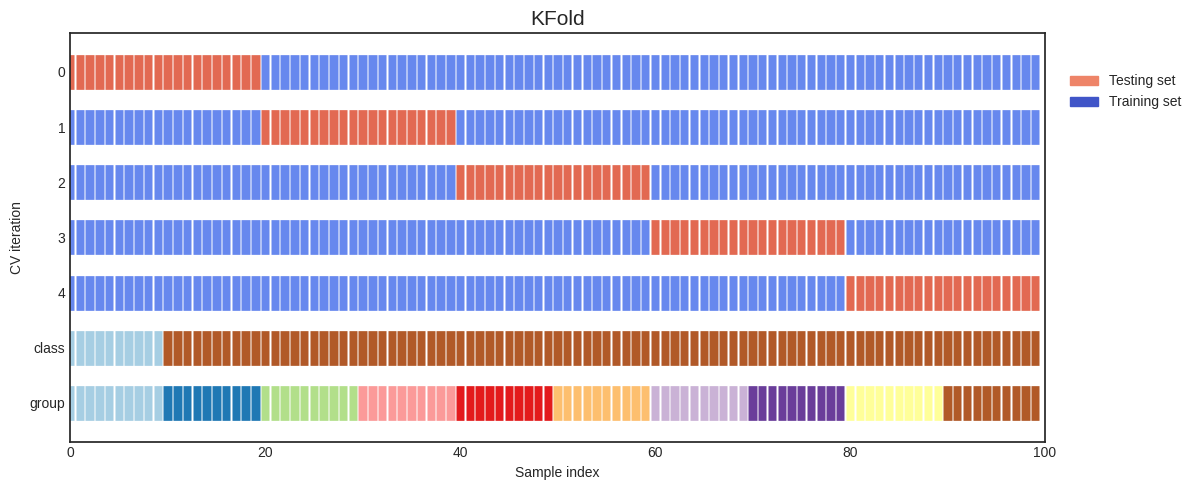

In [58]:
kf = KFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(KFold, X_, y_, groups_)

## Stratified KFold


*   KFold but the folds are made by preserving the percentage of samples for each class.



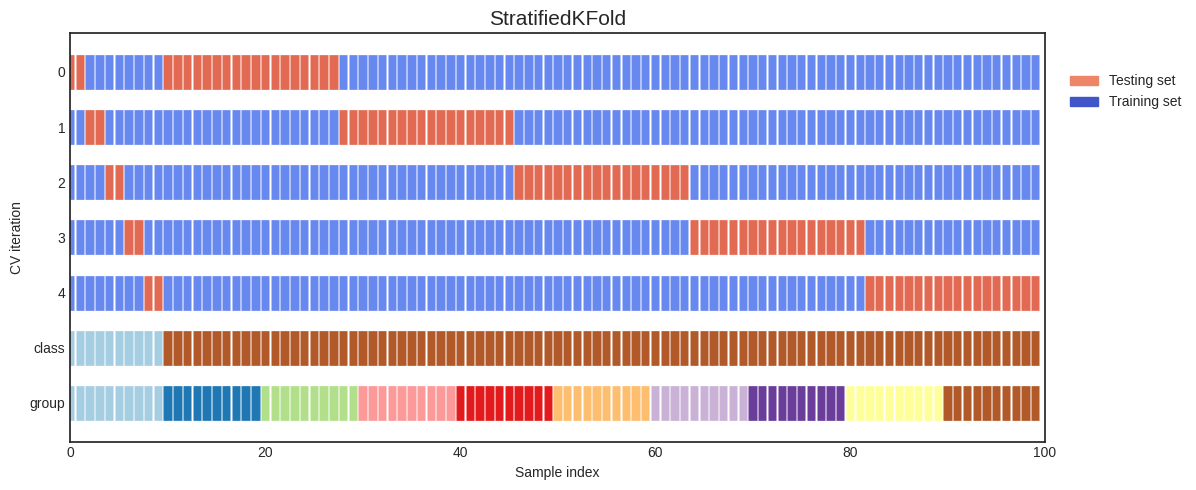

In [59]:
skf = StratifiedKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(StratifiedKFold, X_, y_, groups_)

## Group KFold
The folds are approximately balanced in the sense that the number of distinct groups is approximately the same in each fold.

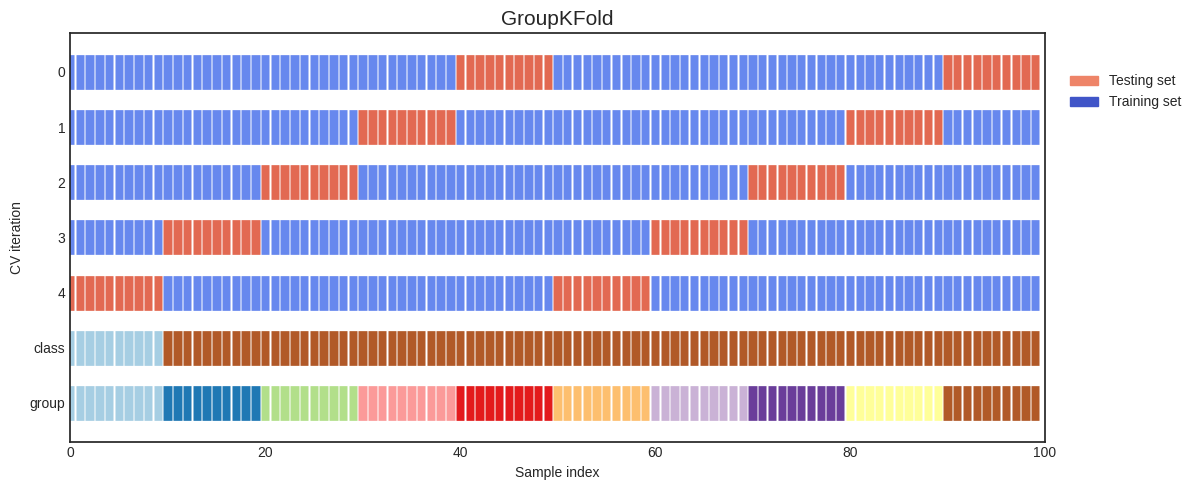

In [60]:
gkf = GroupKFold()
X_, y_, groups_ = get_fake_X_y()
plot_cv(GroupKFold, X_, y_, groups_)

## Stratified Group KFold
The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits.

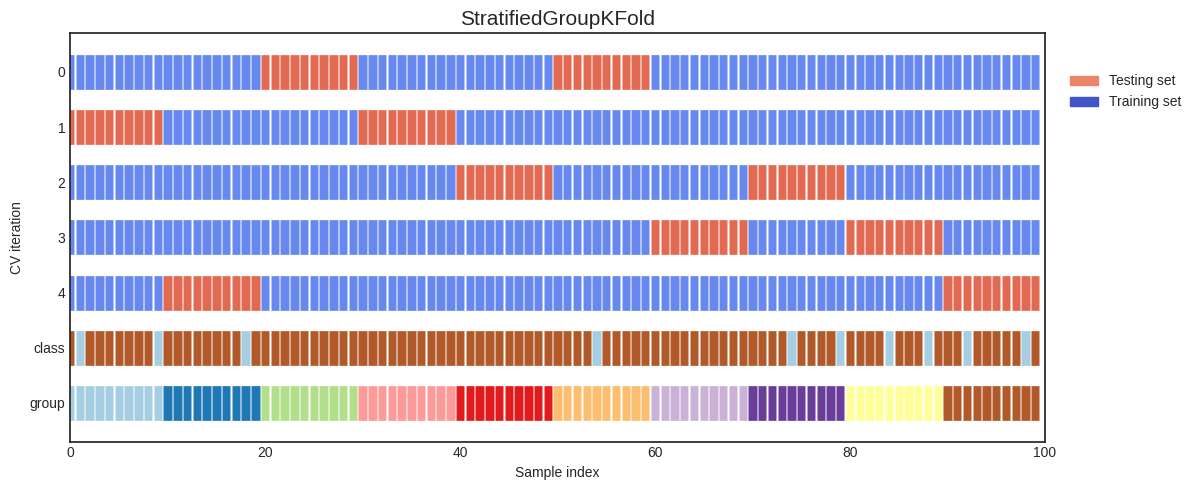

In [61]:
gskf = StratifiedGroupKFold()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(StratifiedGroupKFold, X_, y_, groups_)

## Time Series Split

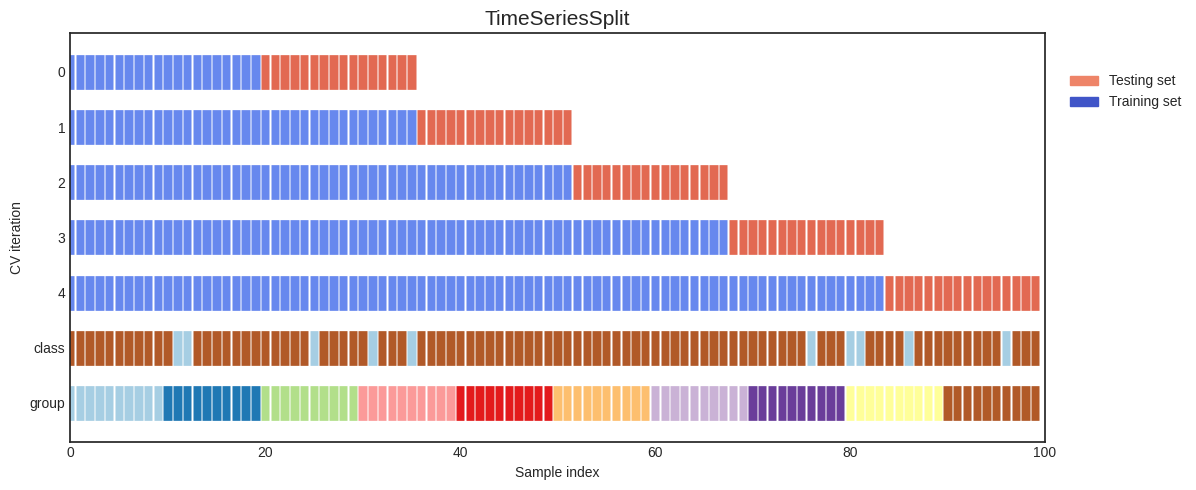

In [62]:
tss = TimeSeriesSplit()
X_, y_, groups_ = get_fake_X_y()
np.random.shuffle(y_)
plot_cv(TimeSeriesSplit, X_, y_, groups_)

# Stratified Group KFold


*   The difference between GroupKFold and StratifiedGroupKFold is that the former attempts to create balanced folds such that the number of distinct groups is approximately the same in each fold, whereas StratifiedGroupKFold attempts to create folds which preserve the percentage of samples for each class as much as possible given the constraint of non-overlapping groups between splits.



In [56]:
sgk = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=529)

X, y, groups = get_X_y(train)

fold = 0
aucs = []
for train_idx, val_idx in sgk.split(X, y, groups):
    X_tr = X.loc[train_idx]
    y_tr = y.loc[train_idx]

    X_val = X.loc[val_idx]
    y_val = y.loc[val_idx]

    # Fit Model on Train
    clf = lgb.LGBMClassifier(n_estimators=100)
    clf.fit(X_tr, y_tr)
    pred = clf.predict(X_val)
    pred_prob = clf.predict_proba(X_val)[:, 1]
    acc_score = accuracy_score(y_val, pred)
    auc_score = roc_auc_score(y_val, pred_prob)
    print(f"======= Fold {fold} ========")
    print(
        f"Our accuracy on the validation set is {acc_score:0.4f} and AUC is {auc_score:0.4f}"
    )
    fold += 1
    aucs.append(auc_score)
oof_auc = np.mean(aucs)
print(f'Our out of fold AUC score is {oof_auc:0.4f}')

[LightGBM] [Info] Number of positive: 177, number of negative: 3245
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000336 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 633
[LightGBM] [Info] Number of data points in the train set: 3422, number of used features: 10
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.051724 -> initscore=-2.908721
[LightGBM] [Info] Start training from score -2.908721
======= Fold 0 ========
Our accuracy on the validation set is 0.9537 and AUC is 0.8349
[LightGBM] [Info] Number of positive: 159, number of negative: 3254
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data 